In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob
import gc
from tqdm import tqdm
import concurrent.futures

# === RDKit for Molecular Processing ===
from rdkit import Chem

# === PyTorch & PyTorch Geometric ===
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.losses import MeanSquaredError

import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error

c:\Users\NongNam\Documents\AI_Builder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load all history files
history_files = sorted(glob.glob('GNN_MODEL/history_epoch_*.pkl'))

val_losses = []

for file in history_files:
    with open(file, 'rb') as f:
        epoch_history = pickle.load(f)
    val_losses.append(epoch_history['val_loss'][-1])  # Assuming last value per epoch is relevant

# Find best epoch
best_epoch = int(history_files[val_losses.index(min(val_losses))].split('_')[-1].split('.')[0])
best_val_loss = min(val_losses)

print(f"✅ Best Epoch: {best_epoch}")
print(f"📉 Best Validation Loss: {best_val_loss:.6f}")


✅ Best Epoch: 51
📉 Best Validation Loss: 1.321657


In [3]:
model = tf.keras.models.load_model(f'GNN_MODEL/model_epoch_{best_epoch}.h5')
model.summary()  # optional

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1000, 64)  │      1,344 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 128) │     73,856 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1000, 128) │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 256) │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1000, 384) │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 384)       │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 595,651 (2.27 MB)

 Trainable params: 594,113 (2.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 2 (12.00 B)

In [4]:
df = pd.read_csv('test_dataset.csv')

In [5]:
# Encode amino acid sequences
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

# Pad protein sequences
max_len_protein = 1000
X_protein = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')

In [6]:
def get_atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic())
    ]

In [7]:
def get_bond_features(bond):
    return [
        int(bond.GetBondTypeAsDouble()),   # Single=1.0, Double=2.0, etc.
        int(bond.GetIsConjugated()),
        int(bond.GetIsAromatic())
    ]

In [8]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    smiles = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(smiles)

    x = torch.tensor([get_atom_features(atom) for atom in mol.GetAtoms()], dtype=torch.float)

    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        bond_feat = get_bond_features(bond)
        edge_attr += [bond_feat, bond_feat]  # Add both directions

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Apply and filter out None values (only valid SMILES)
graph_data_list = []
valid_indices = []

for i, smiles in enumerate(df['SMILES']):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graph_data_list.append(graph)
        valid_indices.append(i)

y_test = df['Kd'].values
# Filter protein and Kd tensors to match valid molecules
X_protein = X_protein[valid_indices]
y_test = y_test[valid_indices]


In [9]:
class GNNEncoder(nn.Module):
    def __init__(self, node_in=5, edge_in=3):
        super().__init__()
        self.edge_nn1 = nn.Sequential(
            nn.Linear(edge_in, 32),
            nn.ReLU(),
            nn.Linear(32, node_in * 64)
        )
        self.conv1 = NNConv(node_in, 64, self.edge_nn1, aggr='mean')

        self.edge_nn2 = nn.Sequential(
            nn.Linear(edge_in, 32),
            nn.ReLU(),
            nn.Linear(32, 64 * 128)
        )
        self.conv2 = NNConv(64, 128, self.edge_nn2, aggr='mean')

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = torch.relu(self.conv1(x, edge_index, edge_attr))
        x = torch.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        return x

In [10]:
# Create a DataLoader for batching the graph data
batch_size = 32  # You can experiment with this size depending on your memory capacity

loader = DataLoader(graph_data_list, batch_size=batch_size, shuffle=False)


In [11]:
# Initialize the GNN encoder model
gnn_model = GNNEncoder()
gnn_model.eval()
gnn_model.cpu()  # Use CPU if GPU memory is limited

# List to store the GNN features
gnn_features_list = []

# Iterate over the DataLoader with tqdm for progress tracking
with torch.no_grad():
    for batch in tqdm(loader, desc="Extracting GNN Features"):
        gnn_features = gnn_model(batch)  # Forward pass through the GNN
        gnn_features_list.append(gnn_features.cpu().numpy())  # Store the features

# Concatenate all the features
gnn_features = np.concatenate(gnn_features_list, axis=0)

Extracting GNN Features: 100%|██████████| 192/192 [00:16<00:00, 11.50it/s]


In [12]:
# Predict
y_pred = model.predict([X_protein, gnn_features]).flatten()

192/192 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 1.5495
Mean Absolute Error: 0.8800
Root Mean Squared Error: 1.2448


C:\Users\NongNam\AppData\Local\Temp\ipykernel_18472\1715855994.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="True Kd", shade=True)
C:\Users\NongNam\AppData\Local\Temp\ipykernel_18472\1715855994.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Predicted Kd", shade=True)


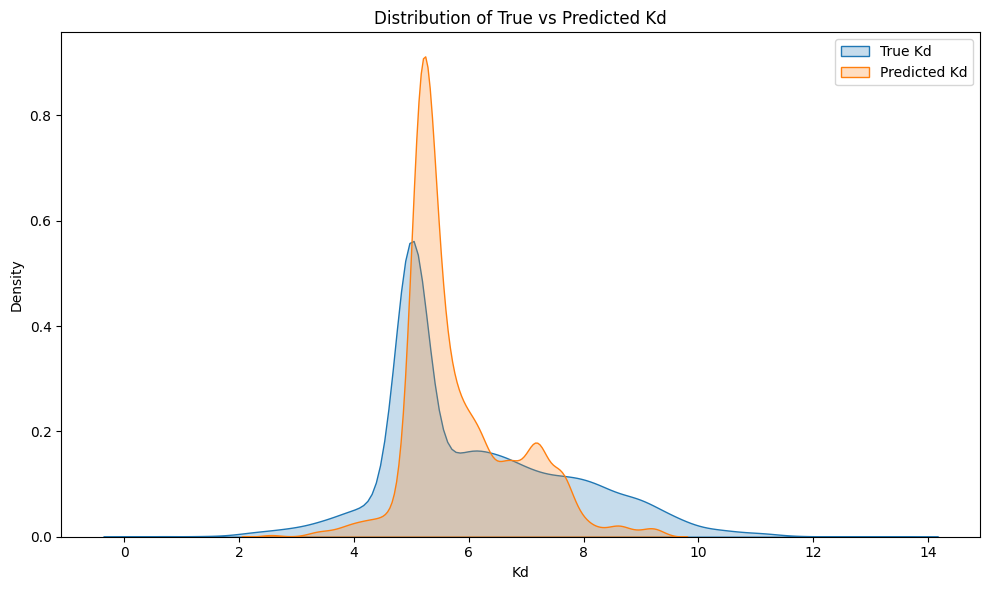

In [14]:
# Plot real vs predicted distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label="True Kd", shade=True)
sns.kdeplot(y_pred, label="Predicted Kd", shade=True)
plt.title("Distribution of True vs Predicted Kd")
plt.xlabel("Kd")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

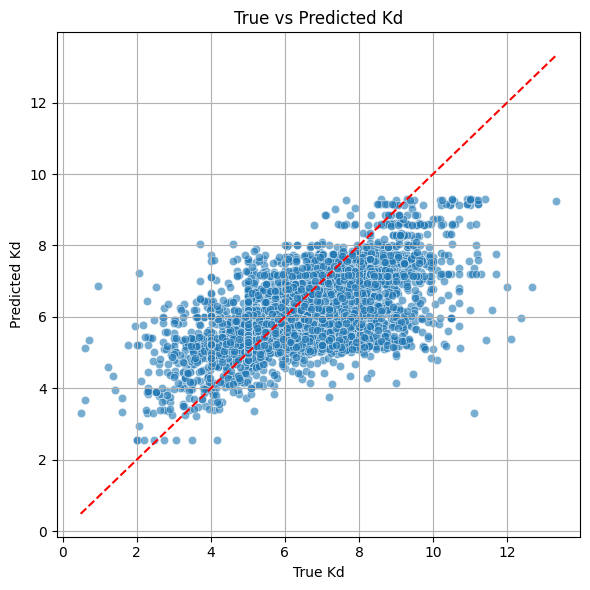

In [15]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # y = x line
plt.xlabel("True Kd")
plt.ylabel("Predicted Kd")
plt.title("True vs Predicted Kd")
plt.grid(True)
plt.tight_layout()
plt.show()


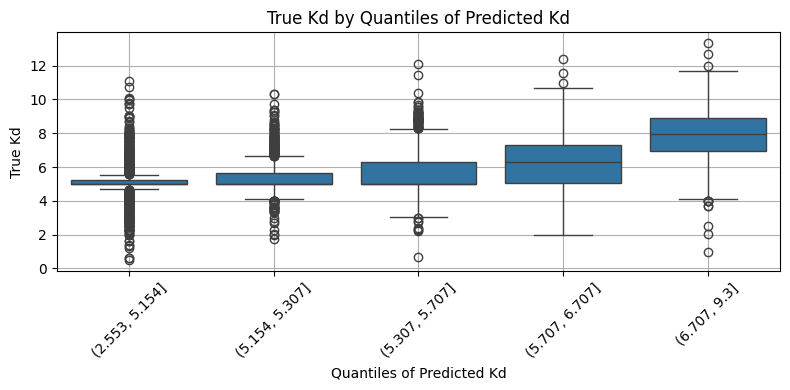

In [16]:
quantiles = pd.qcut(y_pred, q=5, duplicates='drop')  # 5 quantiles (change if needed)
plt.figure(figsize=(8, 4))
sns.boxplot(x=quantiles, y=y_test)
plt.xticks(rotation=45)
plt.xlabel("Quantiles of Predicted Kd")
plt.ylabel("True Kd")
plt.title("True Kd by Quantiles of Predicted Kd")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")

Test MSE: 1.5495
